# Reservoir operation optimisation
In this Notebook we will see how we can optimize the operation of water supply reservoir system using an multiobjective optimizer.

<left><img src="images/Dam2.gif" width = "600px"><left>

As we have seen, when we deal with **two conflicting objectives**, we cannot find a solution that optimise both simoultaneously. If we prioritize one objective, the other one is deteriorated: there is a trade-off between the two. It would then be interesting to explore this tradeoff, and find all the release schedules that produce a different optimal combination of the two objectives. However, this is too cumbersome to do manually. Here we then use a **multi-objective optimisation** algorithm to do that for us. 

To this end, we use the Python Platypus package, and the NSGAII algorithm implemented in it. For more information about these methods and tools, see [Deb et al, 2002](https://ieeexplore.ieee.org/document/996017) and the [Platypus webpage](https://platypus.readthedocs.io). 

As in the previous Notebook "Reservoir operation modelling" we consider a simple illustrative system where a reservoir is operated to supply water to a domestic consumption node. We use a mathematical model to link all the key variables that represent the reservoir dynamics (inflow, storage and outflows) and use model simulation/optimisation to determine the reservoir release scheduling that will best meet the water demand over a coming period of time, given the predicted (or assumed) scenario of future inflows.
    
<left> <img src="images/system_representation_IO0.png" width = "600px"><left>    

## Import libraries
Before getting started, let's import some libraries that will be used throughout the Notebook:

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact # to create interactive elements and figures
from platypus import NSGAII, Problem, Real, Integer # for the multi-objective optimization

## The reservoir model

The mathematical model of the reservoir essentially consists of a water balance equation, where the storage (***s***) at a future time step (for example, at the beginning of the next week) is predicted from the storage at the current time (the beginning of the this week) by adding and subtracting the inflows and outflows that will occur during the temporal interval ahead:

$s(t+1) = s(t) + inflow(t) – evap(t) – env(t) - spill(t) – supply(t)$   

Where

***s(t)*** = reservoir storage at time-step t, in Vol (for example: ML)

***inflow(t)*** = reservoir inflows in the interval [t,t+1], in Vol/time (for example: ML/week).

***evap(t)*** = evaporation from the reservoir surface area in the interval [t,t+1], in Vol/time (for example: ML/week).

***env(t)*** = environmental compensation flow in the interval [t,t+1], in Vol/time (for example: ML/week). 

***spill(t)*** = outflow through spillways (if any) in the interval [t,t+1], in Vol/time (for example: ML/week). 

***supply(t)*** = regulated reservoir release for water supply in the interval [t,t+1], in Vol/time (for example: ML/week). 

<left> <img src="images/system_representation_IO1.png" width = "600px"><left>
    
#### Implementation of the reservoir simulation function
Here we define a function that implements the reservoir simulation, that is, iteratively apply the mass balance equation and reconstruct the temporal evolution of the reservoir variables over the simulation period

In [2]:
def res_sim(inflow,evap,demand,s_0,s_max,env_min,supply):
    
    """
    This is a model that simulates the operation of a single reservoir system. 
    It essentially consists of a water balance equation, 
    where the storage (s) at a future time step is predicted from the storage at the current time 
    by adding and subtracting the inflows and outflows that will occur during the temporal interval ahead

    The inputs of the model are:

    inflow = time series of reservoir inflows [ML]
    evap = time series of evaporation from the reservoir surface area [ML]
    demand = time series of water demand [ML]
    s_0 = initial reservoir storage [ML]
    s_max = maximum storage capacity of the reservoir [ML]
    env_min = minimum environmental flow [ML]
    supply = regulated reservoir release for water supply [ML]
    
    And the outpus are:
    
    s = reservoir storage [ML]
    env = environmental compensation flow [ML]
    spill = outflow through spillways [ML]
    supply = regulated reservoir release for water supply [ML]
    
    """
    
    T = len(inflow) # number of time steps (weeks)
    # Declare output variables

    s = np.zeros(T+1) # reservoir storage in ML

    spill = np.zeros(T) # spillage in ML

    env = np.zeros(T) + env_min # environmental compensation flow
    
    # Initial storage
    s[0] = s_0

    for t in range(T): # Loop for each time-step (week)

        # If at week t the inflow (I) is lower than the minimum environmental compensation (env_min), 
        # then the environmental compensation (env) = inflow (I)  
        if env_min >= inflow[t] :
            env[t] = inflow[t]
        # If the minimum environmental compensation is higher than the water resource available (S + I - E)
        # then the environmental compensation is equal to the higher value between 0 and the resource available
        if env_min >= s[t] + inflow[t] - evap[t]:
            env[t] = max(0,s[t] + inflow[t] - evap[t]) 
        # If the demand is higher than the water resource available (S + I - E - env)
        # then the release for water supply is equal to the higher value between 0 and the resource available            
        if supply[t] >= s[t] + inflow[t] - evap[t] - env[t]:
            supply[t] = min(supply[t],max(0,s[t] + inflow[t] - evap[t] - env[t]))
        # The spillage is equal to the higher value between 0 and the resource available exceeding the reservoir capacity
        spill[t] = max(0,s[t] + inflow[t] - supply[t] - env[t] - evap[t] - s_max)
        # The final storage (initial storage in the next step) is equal to the storage + inflow - outflows
        s[t+1] = s[t] + inflow[t] - supply[t] - env[t]- evap[t] - spill[t]
        
    return s,env,spill,supply

#### Definition of inflow and demand scenarios
Let's assume we want to look at the next 8 weeks the number of weeks, and assume we have forecasts of inflows, evaporation and demand for this period.

In [7]:
inflow = np.array([15,17,19,11,9,4,3,8]) # (ML/week) time series of inflow forecasts
evap = np.array([1,1,2,2,2,2,2,3]) # (ML/week) time series of evaporation forecasts
demand = np.array([13,13,17,18,20,22,25,26]) # (ML/week) time series of demand forecasts
T = len(inflow) # number of time steps (weeks)
weeks = np.arange(1,T+1)

#### Definition of other input parameters
Let's define other variables that are needed for the reservoir system simulation, such as the reservoir storage capacity, the environmental compensation flow, etc.

In [8]:
### Constraints ###
s_max = 150 #  (ML) Maximum storage (=reservoir capacity)
s_min = 0 #  (ML) Minimum storage 
env_min = 2 # (ML/week)   # Environmental compensation flow

### Initial conditions ###
s_0 = 80 # (ML) # Storage volume at the beginning of the simulation period

## Multi-objective optimisation
### Example 1 - Objectives: 1) reduce the number of water deficit failures and 2) their consequences
In this example we would like to make our system more reliable (less frequent water supply failures) and less vulnerable (failures do not produce severe consequences/impacts) at the same time.
We first need to define the objective functions, i.e. functions whose output value is to be minimized or maximized over the set of feasible alternatives (combinations of variable values). In this case we would like to minimize both the **Reliability indicator** and the **Squared Deficit**. Let's define the functions to calculate both:

In [9]:
def reliability(supply, demand):
    T = len(supply)
    x = np.zeros(T)
    
    for t in range(T):
        if supply[t] >= demand[t]:
            x[t] = 0
        else:
            x[t] = 1
            
    REL = np.mean(x)
    return REL  

In [10]:
def SD_func(supply,demand):
    T = len(demand)
    
    sd = np.zeros(T)
    
    for t in range(T):
        sd[t] = np.max(demand[t] - supply[t], 0)**2
    
    SD = np.mean(sd)
    return SD

The code to run the optimisation using the **Non-dominated Sorting Genetic Algorithm (NSGA-II)** is the following:

In [53]:
def auto_optim(vars):
    # First we indicate the variables that the optimizer will define to minimize the objective function.
    # In this case the variables are the release volume for each of the 8 weeks
    rel_1 = vars[0]
    rel_2 = vars[1]
    rel_3 = vars[2]
    rel_4 = vars[3]
    rel_5 = vars[4]
    rel_6 = vars[5]
    rel_7 = vars[6]
    rel_8 = vars[7]
    
    # We create an array with the weekly release volumes
    supply = np.array([rel_1,rel_2,rel_3,rel_4,rel_5,rel_6,rel_7,rel_8])
    # We run the reservoir system model
    s,env,spill,supply = res_sim(inflow,evap,demand,s_0,s_max,env_min,supply)
    
    # Here we run the objective functions
    REL = reliability(supply,demand)
    SD = SD_func(supply,demand)
    
    # As outputs of the function we indicate the values to minimize
    return [REL,SD]

problem = Problem(T,2) # Here we indicate that the optimization problems has T variables and 2 objective functions
# Now we indicate the min and max values that the variables can take. In this case we set 0 and 30 ML
Real0 = Real(0, 30);Real1 = Real(0, 30);Real2 = Real(0, 30);Real3 = Real(0, 30);
Real4 = Real(0, 30);Real5 = Real(0, 30);Real6 = Real(0, 30);Real7 = Real(0, 30)

problem.types[:] = [Real0] + [Real1] + [Real2] + [Real3] + [Real4] + [Real5] + [Real6] + [Real7] 
problem.function = auto_optim

population_size = 6 # number of optimal solutions
algorithm_REL_SD = NSGAII(problem,population_size)
algorithm_REL_SD.run(10000) # Number of iterations/runs

Now we store the results of the optimization as arrays

In [54]:
results_optim_REL = np.array([algorithm_REL_SD.result[i].objectives[0] for i in range(population_size)])
results_optim_SD = np.array([algorithm_REL_SD.result[i].objectives[1] for i in range(population_size)])

solutions_optim_REL_SD = [algorithm_REL_SD.result[i].variables[0:T] for i in range(population_size)]

#### Plot the optimisation results
We can visualise the tradeoffs between the two objectives in one plot, called **Pareto front**, which displays the combination of the two objective values in correspondence to a set of optimised solutions. Click on one point in the Pareto front to visualise the release scheduling that generates that performance, and associated storage time series. **What do you think would be a balanced solution?**

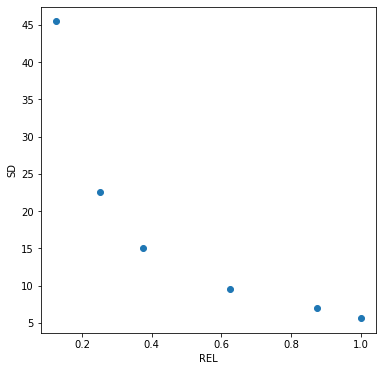

In [66]:
plt.figure(figsize=(6,6)) # to define the plot size
plt.scatter(results_optim_REL,results_optim_SD)
plt.xlabel('REL')
plt.ylabel('SD')
plt.show()

Let´s make a interactive figures to make the exploration of the results easier

#### Play with the number of iterations and see how the Pareto front changes

In [63]:
@interact(iter_num = [200,300,400,500,600,700,800,900,1000,10000])
def pareto_interac_1(iter_num=200):
    
    problem = Problem(T,2) # Here we indicate that the optimization problems has T variables and 2 objective functions
    # Now we indicate the min and max values that the variables can take. In this case we set 0 and 30 ML
    Real0 = Real(0, 30);Real1 = Real(0, 30);Real2 = Real(0, 30);Real3 = Real(0, 30);
    Real4 = Real(0, 30);Real5 = Real(0, 30);Real6 = Real(0, 30);Real7 = Real(0, 30)

    problem.types[:] = [Real0] + [Real1] + [Real2] + [Real3] + [Real4] + [Real5] + [Real6] + [Real7] 
    problem.function = auto_optim

    population_size = 6 # number of optimal solutions
    algorithm_REL_SD = NSGAII(problem,population_size)
    algorithm_REL_SD.run(iter_num) # Number of iterations/runs
    
    results_optim_REL = np.array([algorithm_REL_SD.result[i].objectives[0] for i in range(population_size)])
    results_optim_SD = np.array([algorithm_REL_SD.result[i].objectives[1] for i in range(population_size)])

    solutions_optim_REL_SD = [algorithm_REL_SD.result[i].variables[0:T] for i in range(population_size)]

    # Figure: Pareto front
    plt.figure(figsize=(5,15)) # to define the plot size
    plt.subplot(3,1,1)
    plt.scatter(results_optim_REL,results_optim_SD)
    plt.xlabel('REL [failures/week]')
    plt.ylabel('SD [ML$^2$/week]')
    plt.xlim([0,1])
    plt.ylim([0,50])

interactive(children=(Dropdown(description='iter_num', options=(200, 300, 400, 500, 600, 700, 800, 900, 1000, …

#### Select different optimal solutions and compare the results of the system performance (level of security)

In [65]:
@interact(solution_num=np.arange(population_size))
def pareto_interac_2(solution_num=0):

    # Figure: Pareto front
    plt.figure(figsize=(4,13)) # to define the plot size
    plt.subplot(3,1,1)
    plt.scatter(results_optim_REL,results_optim_SD)
    plt.scatter(results_optim_REL[solution_num],results_optim_SD[solution_num], color = 'red', s = 100)
    plt.xlabel('REL [failures/week]')
    plt.ylabel('SD [ML$^2$/week]')
    plt.xlim([0,1])
    plt.ylim([0,50])
    
    s,env,spill,supply = res_sim(inflow,evap,demand,s_0,s_max,env_min,solutions_optim_REL_SD[solution_num])
    # Figure: supply vs demand
    plt.figure(figsize=(10,6)) # to define the plot size
    plt.subplot(3,1,2)
    plt.bar(weeks,demand, color = 'lightgray', label = 'demand') # bar plot showing the demand volume for each week
    plt.bar(weeks,supply, color = 'green', label = 'releases', alpha = 0.5) 
    plt.ylabel('ML/week')
    plt.ylim([0,35])
    plt.title('Squared deficit = %i ML$^2$/week - Reliability = %.2f failures/week' % (results_optim_SD[solution_num],results_optim_REL[solution_num]))
    plt.legend()
    
    # Figure: reservoir storage
    plt.figure(figsize=(10,6)) # to define the plot size
    plt.subplot(3,1,3)
    plt.plot(s, color = 'blue', label = 'storage') # line presenting the evolution of the reservoir storage volume
    plt.hlines(s_max,xmin = 0, xmax = 8, label = 'max storage',color = 'red') # horizontal line representing the max storage
    plt.hlines(s_min,xmin = 0, xmax = 8, linestyle= '--', label = 'min storage',color = 'red') # horizontal line representing the max storage
    plt.xlabel('week')
    plt.ylabel('ML/week')
    plt.ylim([0,200])
    plt.legend()
    plt.show()

interactive(children=(Dropdown(description='solution_num', options=(0, 1, 2, 3, 4, 5), value=0), Output()), _d…

### Exercise - Objectives: improve the water supply security of our system in terms of 1) quantity and 2) quality
In this exercise you should try to make our system 1)less vulnerable (failures do not produce severe consequences/impacts) and at the same time make sure that 2) the **quality** of the water supplied is adequate. For the objective 2) we are interested in minimising the chances that the reservoir level go below a **minimum threshold** because the **quality** of the water deteriorates when levels are low. We measure how well this criterion is satisfied by the following objective function:

$$MSV = 1/T \sum_{t=1}^{T} max ( \ smin - s(t) , \ 0)$$

where, again, `T` is the length of the simulation period, `s` is the reservoir storage, and `s_min` is the minimum reservoir storage threshold that should preferably not be transpassed (`MSV` stands for **Minimum Storage Violation**). 

We first need to define the objective functions, i.e. functions whose output value is to be minimized or maximized over the set of feasible alternatives (combinations of variable values). In this case we would like to minimize both the **Reliability indicator** and the **MSV**. The Reliability function was already defined above, let's define the function to calculate **MSV**:

In [15]:
def MSV_func(s,s_min):
    
    T = len(s)
    
    msv = np.zeros(T) # weeekly storage violations
    
    for t in range(T):
        msv[t] = np.abs(np.max([s_min - s[t], 0]))
    
    MSV = np.mean(msv) # mean of the weekly storage violations
    return MSV

For our case, let's set this threshold to **30 ML**:

In [16]:
# Minimum storage threshold
s_min = 30 # in ML

The code to run the optimisation is the following:

In [17]:
def auto_optim(vars):
    # First we indicate the variables that the optimizer will define to minimize the objective function.
    # In this case the variables are the release volume for each of the 8 weeks
    rel_1 = vars[0]
    rel_2 = vars[1]
    rel_3 = vars[2]
    rel_4 = vars[3]
    rel_5 = vars[4]
    rel_6 = vars[5]
    rel_7 = vars[6]
    rel_8 = vars[7]
    
    # We create an array with the weekly release volumes
    supply = np.array([rel_1,rel_2,rel_3,rel_4,rel_5,rel_6,rel_7,rel_8])
    # We run the reservoir system model
    s,env,spill,supply = res_sim(inflow,evap,demand,s_0,s_max,env_min,supply)
    
    # Here we run the objective functions
    MSV = MSV_func(s,s_min)
    SD = SD_func(supply,demand)
    
    # As outputs of the function we indicate the values to minimize
    return [MSV,SD]

problem = Problem(T,2) # Here we indicate that the optimization problems has T variables and 2 objective functions
# Now we indicate the min and max values that the variables can take. In this case we set 0 and 30 ML
Real0 = Real(0, 30);Real1 = Real(0, 30);Real2 = Real(0, 30);Real3 = Real(0, 30);
Real4 = Real(0, 30);Real5 = Real(0, 30);Real6 = Real(0, 30);Real7 = Real(0, 30)

problem.types[:] = [Real0] + [Real1] + [Real2] + [Real3] + [Real4] + [Real5] + [Real6] + [Real7] 
problem.function = auto_optim

population_size = 6 # number of optimal solutions
algorithm_MSV_SD = NSGAII(problem,population_size)
algorithm_MSV_SD.run(10000) # Number of iterations/runs

Now we store the results of the optimization as arrays

In [18]:
results_optim_MSV = np.array([algorithm_MSV_SD.result[i].objectives[0] for i in range(population_size)])
results_optim_SD = np.array([algorithm_MSV_SD.result[i].objectives[1] for i in range(population_size)])

solutions_optim_MSV_SD = [algorithm_MSV_SD.result[i].variables[0:T] for i in range(population_size)]

#### Plot the optimisation results
We can visualise the tradeoffs between the two objectives in one plot, called **Pareto front**, which displays the combination of the two objective values in correspondence to a set of optimised solutions. Click on one point in the Pareto front to visualise the release scheduling that generates that performance, and associated storage time series. **What do you think would be a balanced solution?**

In [19]:
@interact(solution_num=np.arange(population_size))
def pareto_interac_2(solution_num=0):
    # Figure: Pareto front
    plt.figure(figsize = (3,10))
    plt.subplot(3,1,1)
    plt.scatter(results_optim_MSV,results_optim_SD)
    plt.scatter(results_optim_MSV[solution_num],results_optim_SD[solution_num], color = 'red', s = 100)
    plt.xlabel('MSV')
    plt.ylabel('SD')
    plt.xlim(0,5)
    plt.ylim(0,50)
    
    # Here we need to run the reservoir model using the results of the of the optimizer = solutions_optim_REL_SD
    # We do this to obtain the actual supply (after applying the water balance: s + inputs - outputs) and 
    # the reservoir storage time series (s) 
    s,env,spill,supply = res_sim(inflow,evap,demand,s_0,s_max,env_min,solutions_optim_MSV_SD[solution_num])
    
    # Figure: supply vs demand
    plt.figure(figsize=(10,6)) # to define the plot size
    plt.subplot(3,1,2)
    plt.bar(weeks,demand, color = 'lightgray', label = 'demand') # bar plot showing the demand volume for each week
    plt.bar(weeks,supply, color = 'green', label = 'releases', alpha = 0.5) 
    plt.ylabel('ML/week')
    plt.ylim([0,35])
    plt.title('Squared deficit = %i ML$^2$/week - MSV = %.2f ML/week' % (results_optim_SD[solution_num],results_optim_MSV[solution_num]))

    # Figure: reservoir storage
    plt.figure(figsize=(10,6)) # to define the plot size
    plt.subplot(3,1,3)
    plt.plot(s, color = 'blue', label = 'storage') # line presenting the evolution of the reservoir storage volume
    plt.hlines(s_min,xmin = 0, xmax = 8, linestyle= '--', label = 'min storage',color = 'red') # horizontal line representing the max storage
    plt.xlabel('week')
    plt.ylabel('ML/week')
    plt.ylim([0,200])
    plt.legend()

interactive(children=(Dropdown(description='solution_num', options=(0, 1, 2, 3, 4, 5), value=0), Output()), _d…

### References 
Deb K. et al (2002) A fast and elitist multiobjective genetic algorithm: NSGA-II, IEEE Transactions on Evolutionary Computation, 6(2), 182-197, doi:10.1109/4235.996017.